In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

import warnings

# Ignorieren von FutureWarnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Business Understanding

Die Folgenden Ziele sind ausgerichtet auf mittelfristigen Investoren mit einer Investitionsdauer von maximal 1–2 Jahren. 

1. **Identifikation von unterbewerteten Immobilien:** Das primäre Ziel des Regressionsmodells ist die präzise Vorhersage des fairen Verkaufspreises. Durch den Vergleich der Modellvorhersage mit den tatsächlichen Angebotspreisen sollen Häuser identifiziert werden, die signifikant unter dem Marktwert angeboten werden.

2. **Ermittlung von Renovierungsmaßnahmen:** Durch die Analyse der Einflussfaktoren soll ermittelt werden, welche Merkmale den größten Einfluss auf den Verkaufspreis haben. Das Ziel ist es, abzuleiten, welche der Renovierungsmaßnahmen den Wert eines Hauses am stärksten steigern, um es innerhalb des Anlagezeitraums gewinnbringend weiterzuverkaufen. Ein Beispiel für eine solche Maßnahme wäre möglicherweise die verbesserung der Qualität des Innenanstrichs des Hauses.

# 2. Data Exploration und Analyse

In [3]:
# Daten Einlesen
data_train = pd.read_csv('data_for_training.csv', sep=';')

# Erste 10 Datensätze ausgeben
data_train.head(10)

,A_Index,Ausbaustufe,Baujahr,Besonderheiten,EG_qm,Gesamtqual,Gesamtzustand,Grundstueck_qm,Kellerhoehe,Lage,QualInnenfarbe,Steigung,Umgebaut,Verkaufsjahr,Wohnflaeche_qm,Z_Verkaufspreis
0,1710,1 Ebene,1960,NaN,166,Durchschnitt,Durchschnitt,1428,Durchschnitt,NeuBerlin_B,3,Keine/Kaum,1960,2009,166,100088
1,1310,1 Ebene,1982,NaN,151,Durchschnitt,Durchschnitt,2365,Gut,NeuBerlin_B,2,Mittel,1982,2006,151,145148
2,2563,1 Ebene,1925,NaN,84,Schlecht,Schlecht,1004,Schlecht,NeuBerlin_A,3,Stark,1953,2011,84,48860
3,373,1 Ebene,1968,NaN,95,Durchschnitt,Durchschnitt,1314,Durchschnitt,NeuBerlin_C,5,Keine/Kaum,1968,2006,95,72349
4,1464,1 Ebene,1979,NaN,133,Gut,Gut,1080,Gut,NeuBerlin_C,5,Keine/Kaum,2007,2007,133,138313
5,776,"1,5 Ebenen",1951,NaN,114,Durchschnitt,Durchschnitt,962,Durchschnitt,NeuBerlin_C,2,Keine/Kaum,1953,2005,155,76230
6,1874,1 Ebene,1954,NaN,124,Durchschnitt,Durchschnitt,931,Schlecht,NeuBerlin_A,4,Keine/Kaum,1954,2008,124,84066
7,65,2 Ebenen,2003,NaN,70,Gut,Durchschnitt,217,Gut,NeuBerlin_A,1,Keine/Kaum,2003,2007,140,106907
8,2289,1 Ebene,1999,NaN,102,Durchschnitt,Durchschnitt,1660,Gut,NeuBerlin_B,2,Mittel,1999,2007,102,93837
9,2390,1 Ebene,1977,Pool,200,Gut,Schlecht,1440,Gut,NeuBerlin_C,2,Keine/Kaum,1977,2006,246,155623


Spalten: A_Index, Ausbaustufe, Baujahr, Besonderheiten, EG_qm, Gesamtqual, Gesamtzustand, Grundstueck_qm, Kellerhoehe, Lage, QualInnenfarbe, Steigung, Umgebaut, Verkaufsjahr, Wohnflaeche_qm, Z_Verkaufspreis

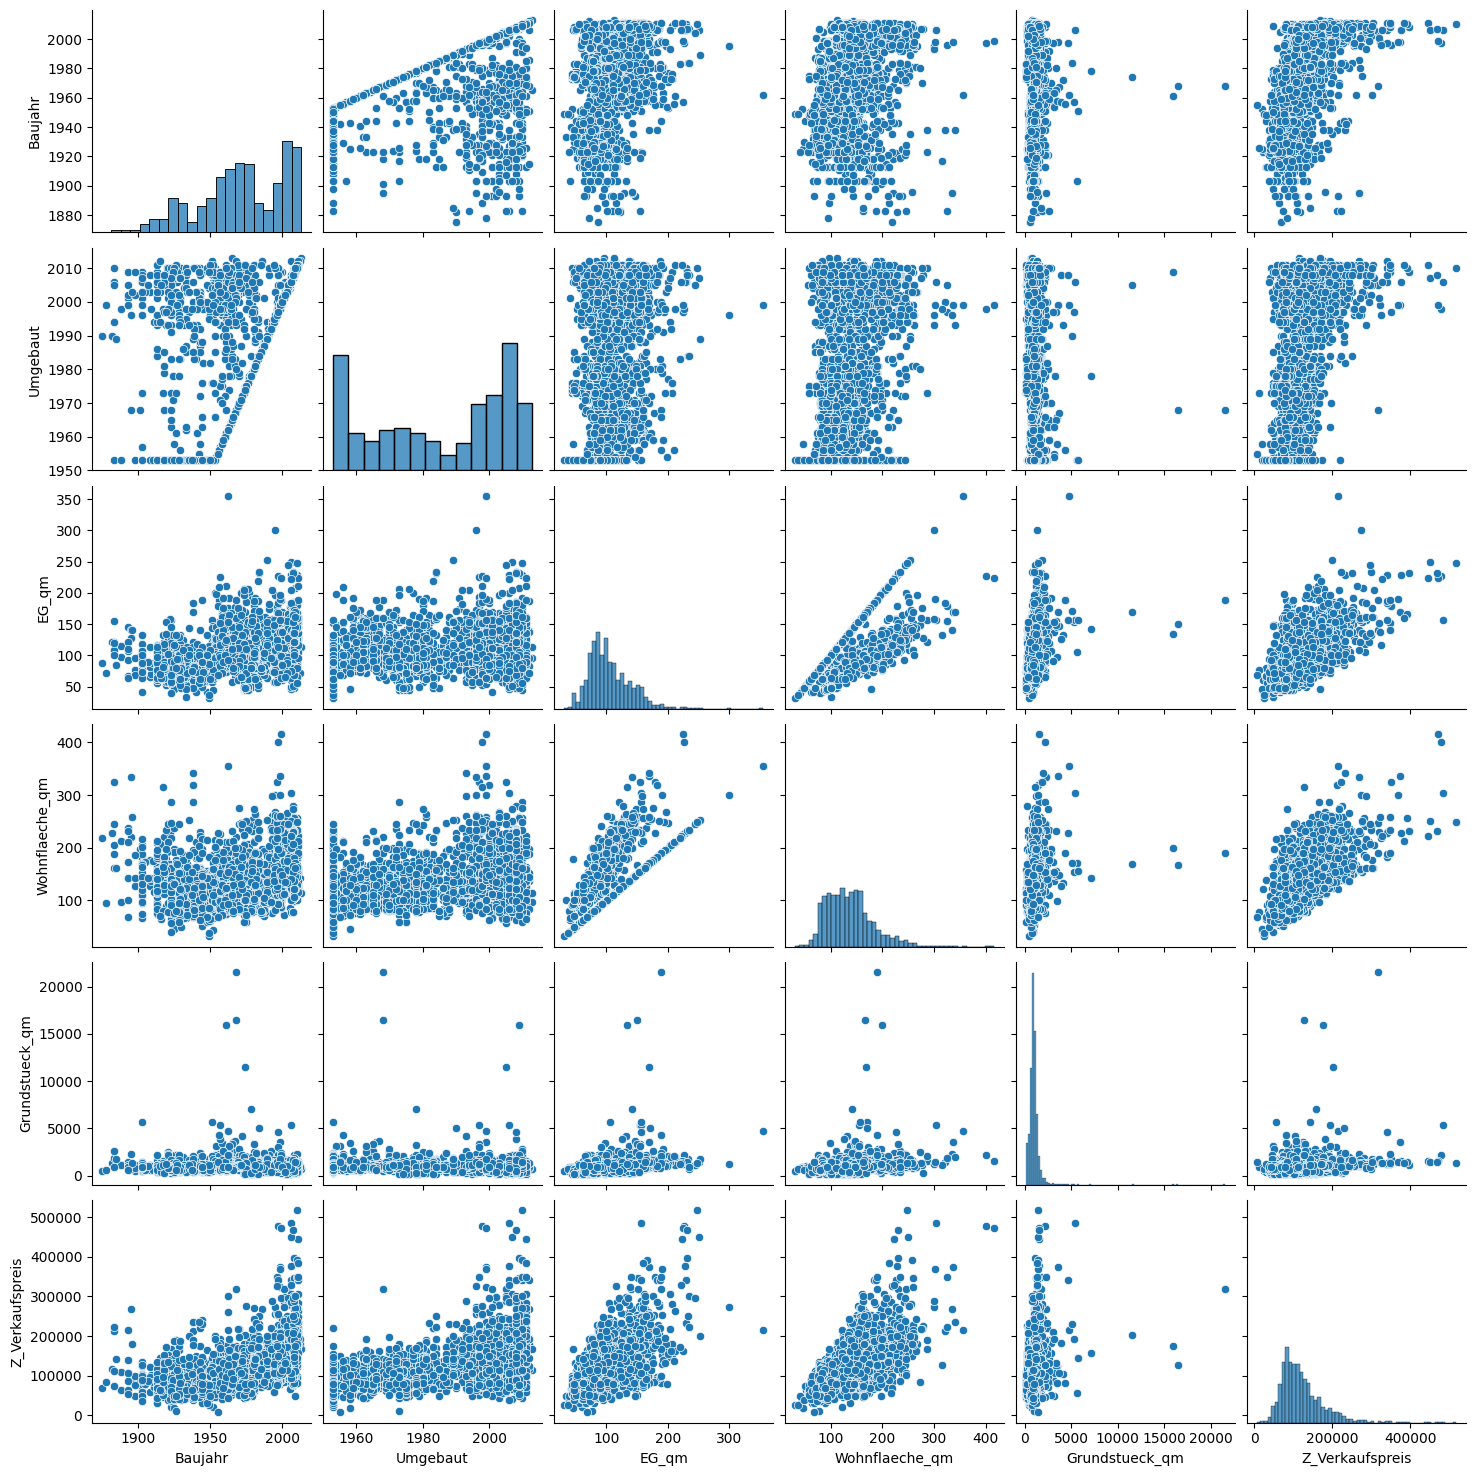

In [9]:
# Wähle gezielte numerische Spalten
special = ['Baujahr', 'Umgebaut', 'EG_qm', 'Wohnflaeche_qm', 'Grundstueck_qm', 'Z_Verkaufspreis']

# Scatterplot erstellen
scatterplot = sns.pairplot(data_train[special])
scatterplot

Basierend auf den allgemeinen Scatterplots, welche die Numerischen Zusammenhänge darstellen, lassen sich folgende Hypothesen und Handlungen ableiten:

- **Preistreiber:** Es ist eine positive Korrelation zwischen `Wohnflaeche_qm` und dem `Z_Verkaufspreis` erkennbar
    - Die Beziehung wirkt weitgehend linear, zeigt aber bei sehr großen Flächen eine zunehmende Varianz
    - `EG_qm` scheint aus den selben gründen positiv mit `Z_Verkaufspreis` korreliert zu sein
- **Ausreißer:** Das Feature `Grundstueck_qm` zeigt massive Ausreißer (einzelne Punkte weit rechts von 5.000qm, jedoch Großteil der Daten < 5.000qm). Diese Ausreißer stauchen die Skala und erschweren das Lernen für lineare Modelle
    - Diese Ausreißer sind zu entfernen, oder zumindest auch zuvor ohne diese zu betrachten, um daraufhin eine Entscheidung über das Vorgehen treffen zu können
- **Alter und Preis:** Neuere Häuser (`Baujahr`) scheinen eher höhere Preise zu haben, die Streuung ist jedoch groß. Vermutbar ist, dass das Baujahr allein nicht reicht und allgemeine Zustand des Hauses (`Gesamtqual` und `Gesamtzustand`), sowie ob das Gebäude Rennoviert wurde (`Umgebaut`) ebenfalls eine Rolle spielt
    - Diese möglichen Zusammenhänge sind zu überprüfen
 - **Umbau:** Das Merkmal `Umgebaut` scheint sich ähnlichen Einfluss auf den Verkaufspreis wie das Merkmal `Baujahr` zu haben. Da Häuser, welche bisher nicht umgebaut wurden hier ihr Baujahr eingetragen haben erscheint dies auch logisch. Häuser welche seit langer zeit nicht umgebaut wurden scheinen einen eher geringeren Verkaufspreis zu haben.

#### Besonderheiten in den Plots
Einige der Plots zeigen unnatürliche Cutoffs in den Datensätzen. Bei genauerer Betrachtung lassen sich diese jedoch erklären.

Die Trennlinie von `Baujahr` mit `Umgebaut` lässt sich dadurch erklären, dass ein Haus erst umgebaut werden kann, nachdem es gebaut wurde. Ferner ist die Trennlinie bei `EG_qm` mit `Wohnfläche_qm` auch logisch. Die Wohnfläche eines Hauses kann in keinem Fall kleiner sein als die Fläche des Erdgeschosses.

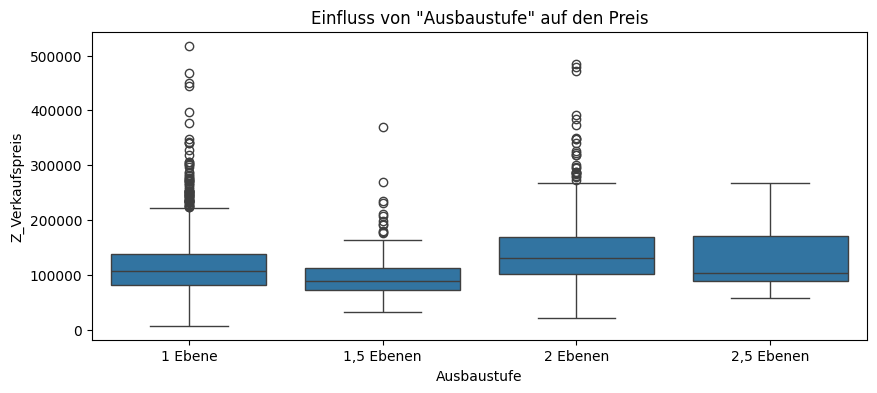

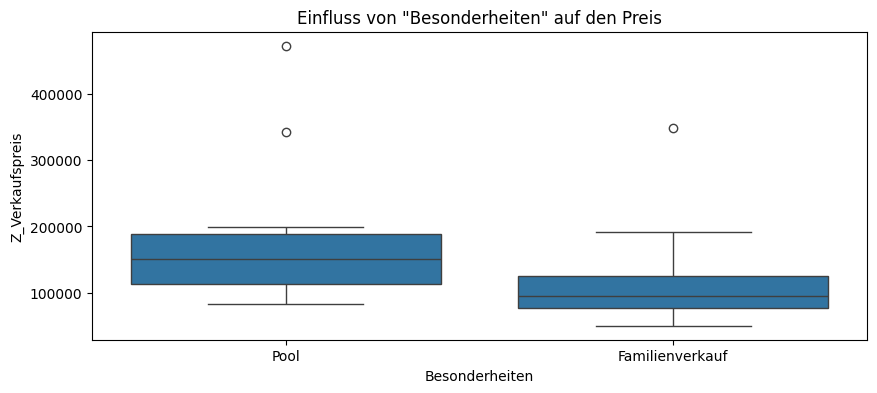

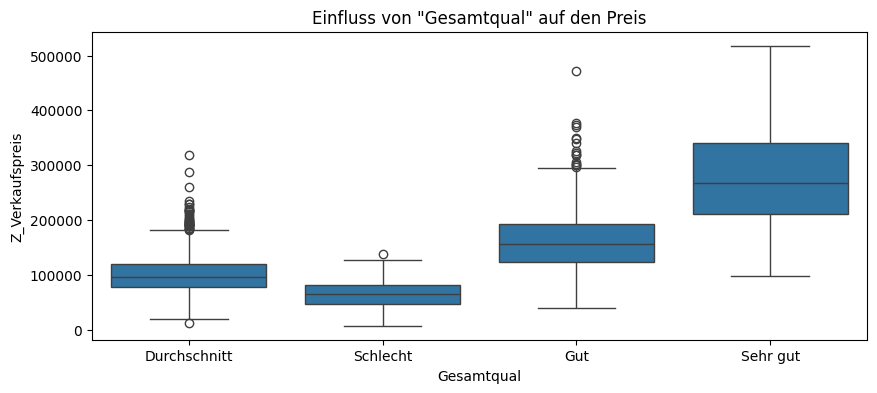

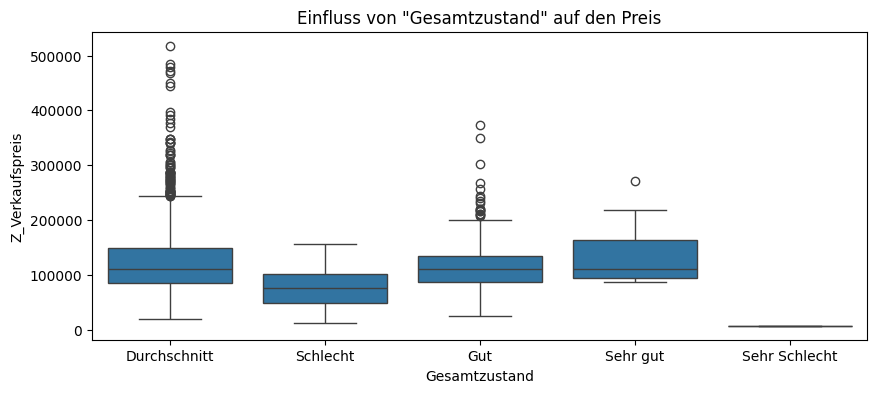

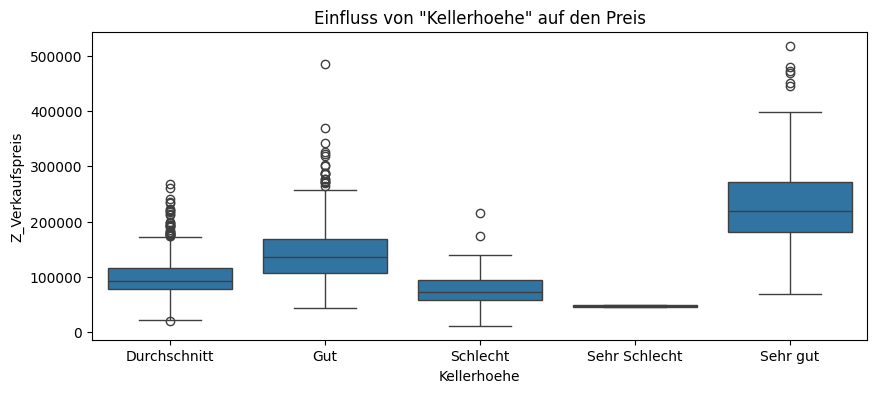

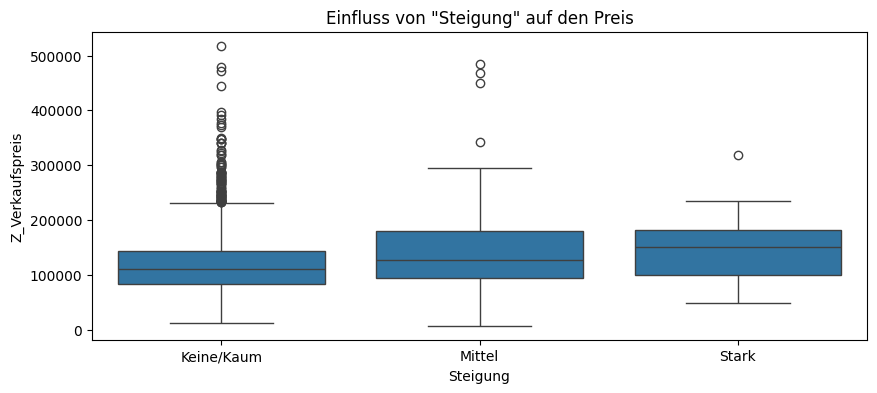

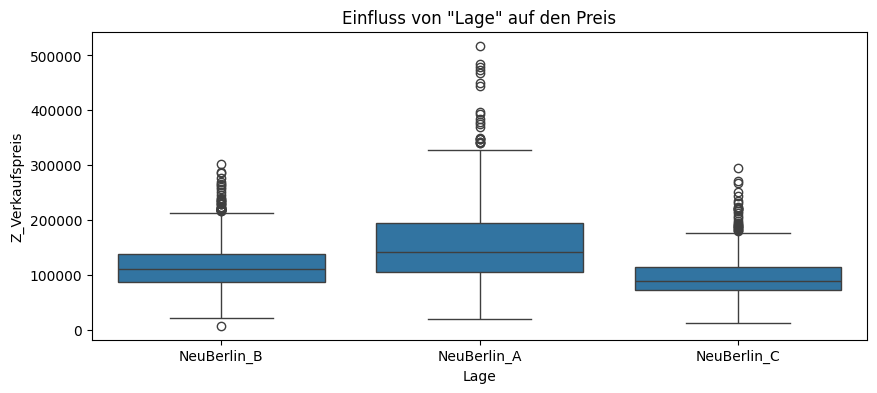

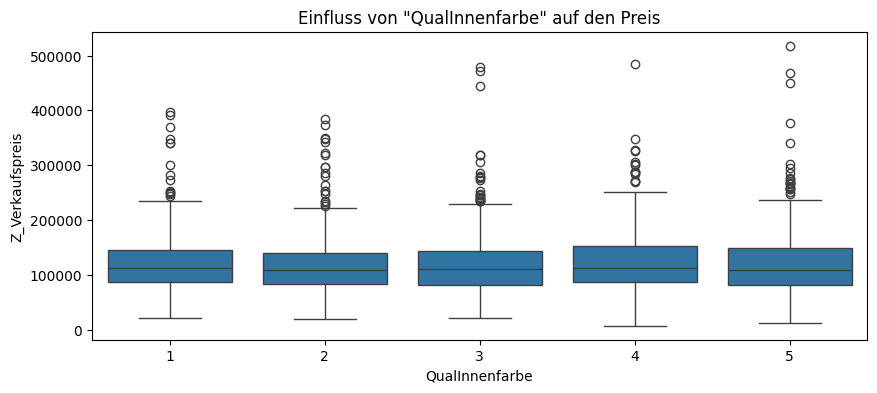

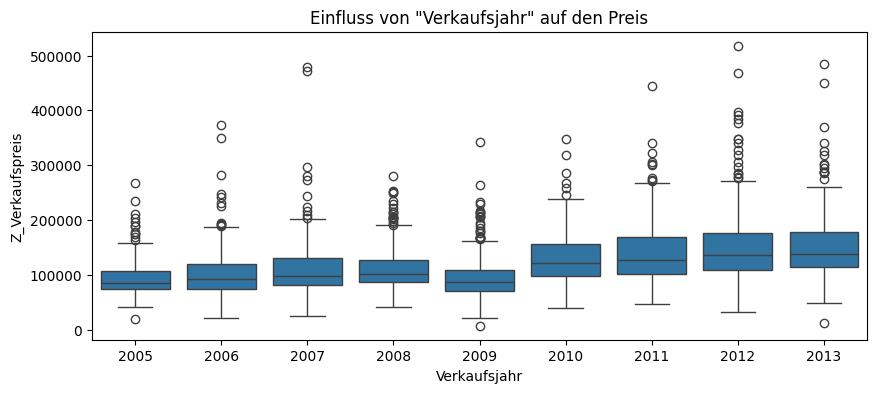

In [7]:
# Wähle kategorische Spalten
categorical = ['Ausbaustufe', 'Besonderheiten', 'Gesamtqual', 'Gesamtzustand', 'Kellerhoehe', 'Steigung', 'Lage', 'QualInnenfarbe', 'Verkaufsjahr']

# Für jede Kategorie einen Plot machen
for column in categorical:
    plt.figure(figsize=(10, 4))
    # Sortierung hilft beim Lesen (optional)
    sns.boxplot(x=column, y='Z_Verkaufspreis', data=data_train)
    plt.title(f'Einfluss von "{column}" auf den Preis')
    plt.show()

**2. Kategorische Einflüsse (Boxplots):**
- **Qualität:** Der Boxplot zu `Gesamtqual` zeigt, dass die Gesamtqualität des Hauses einen Unterschied macht. Je besser die Qualität, umso höher ist der Median-Preis. Die Boxen überlappen sich zudem kaum, was bedeutet, dass dieses Merkmal eine hohe Trennschärfe besitzt
- **Trend und Plausibilität:** Grundsätzlich ist der erwartete Trend erkennbar: Je besser der Zustand (von "Schlecht" zu "Sehr gut"), desto höher tendenziell der Median des Z_Verkaufspreis
    - Besonders die Kategorie "Sehr gut" hebt sich in beiden Merkmalen deutlich durch ein höheres Preisniveau und eine größere Varianz nach oben ab
    - Problem der Unterrepräsentation: Die Kategorie "Sehr Schlecht" zeigt in beiden Plots fast keine Varianz. Dies deutet stark darauf hin, dass hier nur extrem wenige Beobachtungen vorliegen
    - Diese spärliche Besetzung ist für ein Klassifikations-/Regressionsmodell problematisch, da es zu Overfitting auf diese wenigen Ausreißer führen kann
    - Um das Modell zu stabilisieren, sollten die Kategorie "Sehr Schlecht" mit der Kategorie "Schlecht" zusammengefasst werden
- **Steigung:** Häuser mit "Starker" `Steigung` haben einen etwas höheren Median als flache Grundstücke. Dies könnte mit einer besseren Aussicht (Hanglage) korrelieren
-  **Lage:** Geringer Einfluss
- **Besonderheiten:** Der Plot zu `Besonderheiten` zeigt nur "Pool" und "Familienverkauf". Ein Blick in die Rohdaten zeigt viele `NaN`-Werte
    - *Interpretation:* `NaN` bedeutet wahrscheinlich, dass ein Haus keine Besonderheit hat
    - [ ] Im Feature Engineering sollten diese Zeilen nicht gelöscht werden, stattdessen sollten die `NaN`-Werte durch eine Kategorie wie "Standard" ersetzt werden
    - Ein Pool scheint den Preis signifikant zu heben, erkennbar durch den höheren Median
- **Kellerhöhe:** Es ist eine positive Tendenz erkennbar. Kategorien wie "Sehr gut" korrelieren mit deutlich höheren Verkaufspreisen als "Durchschnitt" oder "Schlecht"
    - Auffällig ist die hohe Varianz bei "Sehr gut": Eine sehr gute Kellerhöhe ermöglicht hohe Preise, garantiert sie aber nicht (die Box ist sehr lang gestreckt)
    - Die Kategorie "Sehr Schlecht" wird im Plot lediglich als flache Linie dargestellt. Dies ist ein Indikator für eine extrem geringe Fallzahl. Da diese Kategorie statistisch nicht signifikant ist, sollte sie mit der Kategorie "Schlecht" zusammengefasst werden, ähnlich 
- **Verkaufsjahr:** Geringe Tendenz, dass später verkaufte Häuser auch teurer verkauft wurden
    - *Interpretation*: Umso später ein Haus verkauft wird, umso neuer und somit moderner wird es vermutlich sein
- **Ohne/Wenig Einfluss:**
    - Das Merkmal `Ausbaustufe` scheint nicht logisch mit dem Verkaufspreis korreliert zu sein, die Boxplots zeigen, dass mehr Ebenen nicht direkt einen höheren Verkaufspreis zur folge haben
    - Das Merkmal `QualInnenfarbe` hat den Boxplots zu urteilen keinen Einfluss auf den Verkaufspreis

# 3. Data Preparation